In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim

from numpy import sqrt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import Dense
from torch.utils.data import DataLoader

from tqdm import tqdm

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [50]:
data = pd.read_csv('drive/MyDrive/Colab Notebooks/train_cleaned (4).csv')
test_data = pd.read_csv('drive/MyDrive/Colab Notebooks/clean_test.csv')
test_data = test_data.rename(columns={'YEAR': 'YR', 'MONTH': 'MON', 'HOUR': 'HR', 'WEEKDAY': 'WK_DAY'})

In [51]:
data['START_HR'].unique()

array([13, 14, 17, 16, 18,  3,  4,  7,  8])

In [52]:
vals = test_data['HR'].unique()
vals.sort()
vals

array([ 2,  3,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17])

In [53]:
# test_months = test_data['MON'].unique()

# test_hrs = test_data['HR'].unique()

# test_days = test_data['DAY'].unique()

# test_taxis = test_data['TAXI_ID'].unique()

# data = data[data['MON'].isin(test_months)]
# data = data[data['HR'].isin(test_hrs)]
# data = data[data['DAY'].isin(test_days)]
# #data = data[data['TAXI_ID'].isin(test_taxis)]

In [54]:
# data = data.drop(['STAND_LAT', 'STAND_LONG', 'ORIGIN_CALL', 'ORIGIN', 'YR'], axis=1)

In [55]:
# data.columns

In [56]:
trip_ids = test_data['TRIP_ID']
test_cols = ['CALL_TYPE',
 'ORIGIN_STAND',
 #'TAXI_ID',
 'MON',
 'DAY',
 'HR',
 #'YR',
 'WK_DAY']
test_data = test_data[test_cols]

In [57]:
test_data.columns

Index(['CALL_TYPE', 'ORIGIN_STAND', 'MON', 'DAY', 'HR', 'WK_DAY'], dtype='object')

In [58]:
data = data[['CALL_TYPE',
 'ORIGIN_STAND',
 #'TAXI_ID',
 'MON',
 'DAY',
 'START_HR',
 'WK_DAY',
  'tripTimeSec']].rename(columns={'START_HR':'HR'})

In [59]:
x = test_data['HR'].unique()
x.sort()
x

array([ 2,  3,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17])

In [60]:
sfl = data['HR'].unique()
sfl.sort()
sfl

array([ 3,  4,  7,  8, 13, 14, 16, 17, 18])

In [61]:
#data = pd.read_csv('drive/MyDrive/Colab Notebooks/train_cleaned-4.csv')
#data = data.drop(['STAND_LAT', 'STAND_LONG', 'ORIGIN_CALL', 'ORIGIN'], axis=1)

#test_data = pd.read_csv('drive/MyDrive/Colab Notebooks/clean_test.csv')
#test_data = test_data.rename(columns={'YEAR': 'YR', 'MONTH': 'MON', 'HOUR': 'HR', 'WEEKDAY': 'WK_DAY'})

# trip_ids = test_data['TRIP_ID']
# test_cols = ['CALL_TYPE',
#  'ORIGIN_STAND',
#  'TAXI_ID',
#  'MON',
#  'DAY',
#  'HR',
#  #'YR',
#  'WK_DAY']
# test_data = test_data[test_cols]

def make_mapping(ser):
    '''creates a mapping'''
    mapping = dict(zip(ser.unique(), np.arange(len(ser.unique()))))
    return mapping, len(ser.unique())

def encode(ser, mapping):
    '''encodes a series based on a given mapping '''
    return ser.map(mapping)


encode_cols = ['CALL_TYPE',
 'ORIGIN_STAND',
 #'TAXI_ID',
 #'YR',
 'WK_DAY']

mapping_dict = dict()
n_categories = []
for col in encode_cols:
    dat_col = data[col]
    test_col = test_data[col]
    
    # make sure the test and the train data have the same mapping!
    combined = pd.concat([dat_col, test_col])
    
    # prevent weird encoding imbalance if there are some encodings that appear in 
    # one but not the other
    combined = combined.sample(frac=1)
    
    mapping, n_cat = make_mapping(combined)
    
    n_categories.append(n_cat)
    
    data[col] = encode(dat_col, mapping)
    test_data[col] = encode(test_col, mapping)

    
    
dat_to_idx = dict()
idx_to_dat = dict()
count = 0
# (column index, categorical encoding)
for i, col in enumerate(data.columns):
    unique_vals = np.unique(data[col])
    for val in unique_vals:
        dat_to_idx[(i, val)] = count
        idx_to_dat[count] = (i, val)
        count += 1
        
VOCAB_SIZE = count


def vocabularize(df):
    df = df.copy()
    for i, col in enumerate(df.columns): 
        s = df.shape[0]
        arr = (np.ones(s) * i ).astype(int)
        ser = df[col]

        df[col] = pd.Series(zip(arr, ser)).map(dat_to_idx)
    
    return df

# TRYING OUT LSTM!

# COMMENT THESE OUT WHEN RUNNING LSTM
# data_times = data['tripTimeSec']
# test_times = data['tripTimeSec']

vocab_data = vocabularize(data)
vocab_test_data = vocabularize(test_data)

# # COMMENT THESE OUT WHEN RUNNING LSTM
# vocab_data['tripTimeSec'] = data_times
# vocab_test_data['tripTimeSec'] = test_times


# # check if worked (there should be no NaNs)
print('train nans:', vocab_data.isna().sum(axis=0))
print('test nans:', vocab_test_data.isna().sum(axis=0))

data = vocab_data
test_data = vocab_test_data

test_data = test_data.fillna(109)
print('test nans:', test_data.isna().sum(axis=0))

# CREATE TEST, TRAIN, VALIDATION SETS
# Create X and y for train and test!
selected_cols = ['CALL_TYPE', 'ORIGIN_STAND', 'MON', 'DAY', 'HR',
       'WK_DAY'] # make sure the columns are in the same order!
data = data.sample(frac = 1)

# train size
train_prop = .999
train_idx = int(data.shape[0] * train_prop)

data_train = data[:train_idx]
data_val = data[train_idx:]

X = data_train.drop(['tripTimeSec'],axis=1)[selected_cols].values
y = data_train['tripTimeSec'].values

X_val = data_val.drop(['tripTimeSec'],axis=1)[selected_cols].values
y_val = data_val['tripTimeSec'].values

DAT_FEATURES = X.shape[1]

# DO NOT SHUFFLE!
X_test = test_data[selected_cols].values

train nans: CALL_TYPE       0
ORIGIN_STAND    0
MON             0
DAY             0
HR              0
WK_DAY          0
tripTimeSec     0
dtype: int64
test nans: CALL_TYPE       0
ORIGIN_STAND    0
MON             0
DAY             0
HR              7
WK_DAY          0
dtype: int64
test nans: CALL_TYPE       0
ORIGIN_STAND    0
MON             0
DAY             0
HR              0
WK_DAY          0
dtype: int64


In [62]:
dat_to_idx

{(0, 0): 0,
 (0, 1): 1,
 (0, 2): 2,
 (1, 0): 3,
 (1, 1): 4,
 (1, 2): 5,
 (1, 3): 6,
 (1, 4): 7,
 (1, 5): 8,
 (1, 6): 9,
 (1, 7): 10,
 (1, 8): 11,
 (1, 9): 12,
 (1, 10): 13,
 (1, 11): 14,
 (1, 12): 15,
 (1, 13): 16,
 (1, 14): 17,
 (1, 15): 18,
 (1, 16): 19,
 (1, 17): 20,
 (1, 18): 21,
 (1, 19): 22,
 (1, 20): 23,
 (1, 21): 24,
 (1, 22): 25,
 (1, 23): 26,
 (1, 24): 27,
 (1, 25): 28,
 (1, 26): 29,
 (1, 27): 30,
 (1, 28): 31,
 (1, 29): 32,
 (1, 30): 33,
 (1, 31): 34,
 (1, 32): 35,
 (1, 33): 36,
 (1, 34): 37,
 (1, 35): 38,
 (1, 36): 39,
 (1, 37): 40,
 (1, 38): 41,
 (1, 39): 42,
 (1, 40): 43,
 (1, 41): 44,
 (1, 42): 45,
 (1, 43): 46,
 (1, 44): 47,
 (1, 45): 48,
 (1, 46): 49,
 (1, 47): 50,
 (1, 48): 51,
 (1, 49): 52,
 (1, 50): 53,
 (1, 51): 54,
 (1, 52): 55,
 (1, 53): 56,
 (1, 54): 57,
 (1, 55): 58,
 (1, 56): 59,
 (1, 57): 60,
 (1, 58): 61,
 (1, 59): 62,
 (1, 60): 63,
 (1, 61): 64,
 (1, 62): 65,
 (2, 1): 66,
 (2, 2): 67,
 (2, 3): 68,
 (2, 4): 69,
 (2, 5): 70,
 (2, 6): 71,
 (2, 7): 72,
 (2, 8):

In [63]:
data['HR'].unique()

array([116, 117, 114, 112, 109, 110, 111, 113, 115])

In [64]:

import torch
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y
    
    def __len__(self):
        return len(self.data)


# Create an instance of your dataset
dataset = MyDataset(X, y)

# Define the batch size for training and validation
batch_size = 1024

val_dataset = MyDataset(X_val, y_val)

# Create the dataloaders
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # For training
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # For validation


class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(out)
        output = torch.log_softmax(output, dim=1)
        return output

embedding_dim = 20
num_layers = 4  # Number of LSTM layers
dropout = 0.5  # Dropout rate
model = LSTMModel(VOCAB_SIZE, embedding_dim, hidden_dim=256, num_layers=num_layers, dropout=dropout)
model = model.to(device)


# model = LSTMModel(VOCAB_SIZE, embedding_dim, hidden_dim=256)
# model = model.to(device)
loss_function = nn.NLLLoss() # Negative Log Likelihood loss
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 15
# Loop over each epoch
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    total_train_loss = 0  # Keep track of total training loss
    # Train on batches of data
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(dataloader)
    
    # After training for each epoch, check the loss on validation set
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0  # Keep track of total validation loss
    # Validate on batches of data
    for inputs, targets in validation_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(validation_dataloader)
    
    # Print the average loss for this epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
          #, Validation Loss: {avg_val_loss}')




  7%|▋         | 1/15 [00:01<00:16,  1.21s/it]

Epoch 1/15, Training Loss: 4.792718700567881, Validation Loss: 4.629567623138428


 13%|█▎        | 2/15 [00:02<00:15,  1.19s/it]

Epoch 2/15, Training Loss: 4.649645928541819, Validation Loss: 4.52487850189209


 20%|██        | 3/15 [00:03<00:14,  1.18s/it]

Epoch 3/15, Training Loss: 4.5976215362548825, Validation Loss: 4.477680206298828


 27%|██▋       | 4/15 [00:04<00:12,  1.17s/it]

Epoch 4/15, Training Loss: 4.580841096242269, Validation Loss: 4.468291282653809


 33%|███▎      | 5/15 [00:05<00:11,  1.17s/it]

Epoch 5/15, Training Loss: 4.57277983824412, Validation Loss: 4.485115051269531


 40%|████      | 6/15 [00:07<00:10,  1.21s/it]

Epoch 6/15, Training Loss: 4.566972740491232, Validation Loss: 4.478261470794678


 47%|████▋     | 7/15 [00:08<00:09,  1.19s/it]

Epoch 7/15, Training Loss: 4.563841350873312, Validation Loss: 4.476320743560791


 53%|█████▎    | 8/15 [00:09<00:08,  1.18s/it]

Epoch 8/15, Training Loss: 4.559273258845011, Validation Loss: 4.489352703094482


 60%|██████    | 9/15 [00:10<00:07,  1.17s/it]

Epoch 9/15, Training Loss: 4.556460241476695, Validation Loss: 4.4898295402526855


 67%|██████▋   | 10/15 [00:11<00:05,  1.17s/it]

Epoch 10/15, Training Loss: 4.5526948650678, Validation Loss: 4.487026691436768


 73%|███████▎  | 11/15 [00:13<00:04,  1.21s/it]

Epoch 11/15, Training Loss: 4.549892445405324, Validation Loss: 4.491542339324951


 80%|████████  | 12/15 [00:14<00:03,  1.20s/it]

Epoch 12/15, Training Loss: 4.545718789100647, Validation Loss: 4.489068031311035


 87%|████████▋ | 13/15 [00:15<00:02,  1.20s/it]

Epoch 13/15, Training Loss: 4.543068794409434, Validation Loss: 4.4947052001953125


 93%|█████████▎| 14/15 [00:16<00:01,  1.19s/it]

Epoch 14/15, Training Loss: 4.540781299273173, Validation Loss: 4.495176792144775


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]

Epoch 15/15, Training Loss: 4.536699036757152, Validation Loss: 4.487817287445068


In [83]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        x = self.data[index]
        return x
    
    def __len__(self):
        return len(self.data)

test_dataset = TestDataset(X_test)
test_dataloader = DataLoader(X_test, batch_size=1, shuffle=False)  # For testing

model.eval()  # Set the model to evaluation mode
predictions = []  # Store the predictions here


# # Loop over the test data
# for inputs in test_dataloader:
#     inputs = inputs.to(device).long()  # Convert inputs to Long
#     with torch.no_grad():
#         outputs = model(inputs)
#         predicted = torch.argmax(outputs, dim=1)  # Get the index of the max log-probability.
#         predictions.extend(predicted.tolist())


# Loop over the test data
for inputs in test_dataloader:
    inputs = inputs.to(device).long()
    with torch.no_grad():
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)  # Get the index of the max log-probability.
        predictions.extend(predicted.tolist())

# Now, predictions contain the predicted classes of the test set


In [84]:
preds = pd.Series(predictions).map(idx_to_dat).apply(lambda x: x[1])
preds

0      600
1      570
2      600
3      495
4      540
      ... 
315    555
316    495
317    450
318    555
319    555
Length: 320, dtype: int64

In [85]:
preds_df = pd.DataFrame({'TRIP_ID': trip_ids, 'TRAVEL_TIME': preds})
preds_df

,TRIP_ID,TRAVEL_TIME
0,T1,600
1,T2,570
2,T3,600
3,T4,495
4,T5,540
...,...,...
315,T323,555
316,T324,495
317,T325,450
318,T326,555


(array([ 80., 177.,  43.,   9.,   2.,   0.,   0.,   2.,   2.,   5.]),
 array([ 285.,  519.,  753.,  987., 1221., 1455., 1689., 1923., 2157.,
        2391., 2625.]),
 <BarContainer object of 10 artists>)

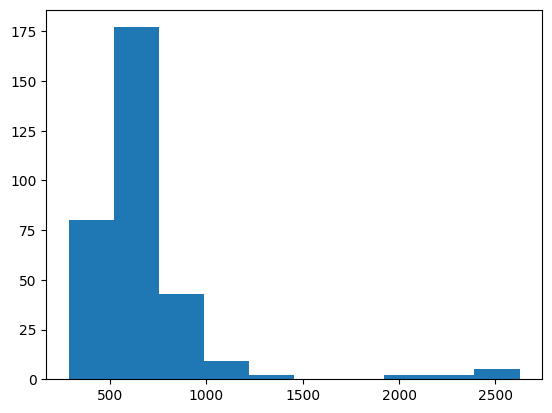

In [86]:
plt.hist(preds)

(array([ 80., 177.,  43.,   9.,   2.,   0.,   0.,   2.,   2.,   5.]),
 array([ 285.,  519.,  753.,  987., 1221., 1455., 1689., 1923., 2157.,
        2391., 2625.]),
 <BarContainer object of 10 artists>)

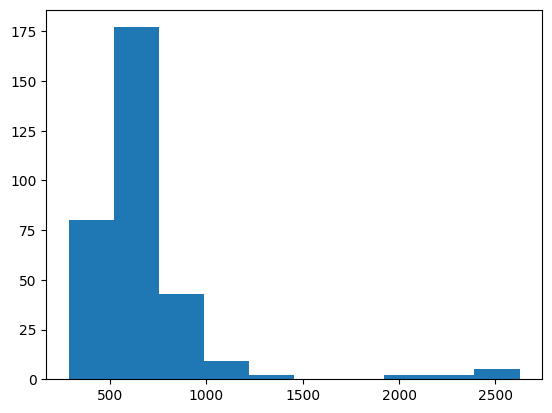

In [68]:
plt.hist(preds)

In [69]:
preds_df.to_csv('drive/MyDrive/Colab Notebooks/preds.csv', index=False)

In [79]:
best_model = model

In [80]:
best_model

LSTMModel(
  (embedding): Embedding(310, 20)
  (lstm): LSTM(20, 256, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=310, bias=True)
)

In [81]:
torch.save(model, 'drive/MyDrive/Colab Notebooks/best_model.pt')

In [82]:
did_work = torch.load('drive/MyDrive/Colab Notebooks/best_model.pt')